This notebook will ensure that you can run the measurement code, and moreover, it will outline what the different components of the notebook accomplish. The purpose of each section of the notebook should be clear and users should be able to create real measurements after creating their own subclasses for their specific setup. 

In [1]:
from dreye.hardware import dummy_system
from dreye.hardware import dummy_spectrometer
from dreye import create_gaussian_spectrum
import numpy as np
import matplotlib.pyplot as plt
import warnings
np.random.seed(10)

First, specify the wavelength range you are interested in (in this case we used a range of 100 to 1000 nm, with steps of 0.1nm). Then, create dummy LEDS using the **create_gaussian_spectrum** class. We chose to create 6. You can plot these spectra for visualizaiton purposes. 

In [2]:
wls = np.arange(250, 800, 0.2)
dummy_leds = create_gaussian_spectrum(
    wls, 
    [340, 360, 415, 455, 565, 615], 
    std=8, 
    max_normalized=True,
    units='spectralirradiance'
)

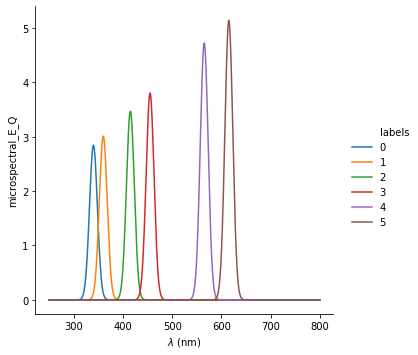

In [3]:
dummy_leds.to('uE').plot()

Next, create dummy voltage analog outputs (AOs). 
 - Specify the names of the LEDS (our examples range from dUV to orange)
 - Specify the channel names as a list of strings. The channel names correspond to the method by which the LEDs in the system are controlled- in this case we are using the National Instruments subclass for the sake of testing, but subclasses exist for other devices (e.g. Arduino). 
 - Specify zero boundaries: the value of each LED which results in a 0 intensity 
 - Specify the max boundariers: the max value possible for each LED. * * Note: you can change units to time, if you are using alternate intensity methods such as pulse width modulation. <br><br> Overall, this cell creates list of dummy AOs and puts them all into one system.

In [3]:
leds = ['duv', 'uv', 'violet', 'rblue', 'lime', 'orange']
channels = ['Dev2/ao1', 'Dev3/ao1', 
            'Dev3/ao0', 'Dev1/ao1', 
            'Dev2/ao0', 'Dev1/ao0']
zeros = [4.4] * 5 + [0.]
maxs = [0.] * 5 + [5.]

outputs = []
for led, ch, z, m in zip(leds, channels, zeros, maxs):
    outputs.append(
        dummy_system.DummyOutput(
            ch, led, 
            zero_intensity_bound=z, 
            max_intensity_bound=m, 
            units='V'
        )
    )

Next, create **system**, which is a method to control all of the LEDs simultaneously.

In [4]:
system = dummy_system.DummySystem(outputs)

You can see the details of each dummy output below:

In [5]:
system

DummySystem contains:
DummyOutput(object=Dev2/ao1, name=duv, max=0.0 volt, zero=4.4 volt)
DummyOutput(object=Dev3/ao1, name=uv, max=0.0 volt, zero=4.4 volt)
DummyOutput(object=Dev3/ao0, name=violet, max=0.0 volt, zero=4.4 volt)
DummyOutput(object=Dev1/ao1, name=rblue, max=0.0 volt, zero=4.4 volt)
DummyOutput(object=Dev2/ao0, name=lime, max=0.0 volt, zero=4.4 volt)
DummyOutput(object=Dev1/ao0, name=orange, max=5.0 volt, zero=0.0 volt)

Next, create a dummy spectrophotometer. Specify the desired level of artificial noise. 

In [20]:
spec = dummy_spectrometer.DummySpectrometer(
    wls, 
    dummy_leds, 
    system,
    noise_scale=0.5, 
)

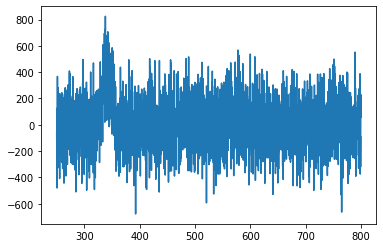

In [21]:
plt.plot(wls, spec.intensities)

**runner** is a class that you pass your spectrophotometer and system instance to. 
 - wls: If set to none, wavelengths measured will be set to whatever is spit out by the spectrophotometer. Alternatively, provide a numpy array with specific values (see comment). 
 - smoothing window: boxcar smoothing window to smooth the spectrum of each averaged intensity value of each LED
 - n_steps: the number of steps from 0 boundary to max boundary per LED, inclusive
 - n_avg: the number of times each step is averaged over
 - remove_zero: substracts the zero boundary from all the other measurements. if you dont want to remove it, set it to false. 

We entered arbitrary numbers here, but we reccomend starting with the default values when running an actual measurement. Therefore, initially specifying keywords may be unecessary. Tweak the parameters as needed. 

In [22]:
from dreye.hardware.measurement_runner import MeasurementRunner

In [28]:
runner = MeasurementRunner(
    system, 
    spec, 
    wls=np.arange(300, 700, 1), 
    smoothing_window=10, 
    n_steps=10, 
    n_avg=100, 
    remove_zero=False, 
)

You're now ready to run the measurement. Set the verbosity level: **verbose**=0 will display nothing, verbose=1 will display minimal updates, verbose=2 will display both voltages for the LED measurements and photons counted per second.

In [29]:
runner.run(verbose=2)


---------------------STARTING MEASUREMENTS-----------------------

-----------------------------------------------------------------
Starting measurement for duv.
sending 10 values
step 0: 4.4 volt == 0.0 photons/second
step 1: 3.9111111111111114 volt == 4365448.579988147 photons/second
step 2: 3.4222222222222225 volt == 9497292.671217963 photons/second
step 3: 2.9333333333333336 volt == 13252887.135192603 photons/second
step 4: 2.4444444444444446 volt == 17408350.48081211 photons/second
step 5: 1.9555555555555557 volt == 21868228.810546767 photons/second
step 6: 1.4666666666666668 volt == 25933785.518563867 photons/second
step 7: 0.9777777777777779 volt == 31570047.89796574 photons/second
step 8: 0.48888888888888893 volt == 36117207.18106637 photons/second
step 9: 0.0 volt == 41256760.10749286 photons/second
Finished measurement for "duv".
-----------------------------------------------------------------

Finished conversion of measurement for "duv".

--------------------------------

After the measurement, the system will have a new attribute called **spms**- standing for spectral measurement. This attribute is its own class containing wavelength values across intensities, and is used for fitting photoreceptors. You can also plot **spms** to visualize your measurements. 

In [30]:
print(system.measured_spectra)

MeasuredSpectraContainer(
	MeasuredSpectrum(
	 name=duv, 
	 units=microspectral_E_Q, 
	 domain=Domain(start=300.0, end=699.0, interval=1.0, units=nanometer), 
	 labels=Domain(start=4.4, end=0.0, interval=-0.48888888888888893, units=volt) 
 );
	MeasuredSpectrum(
	 name=uv, 
	 units=microspectral_E_Q, 
	 domain=Domain(start=300.0, end=699.0, interval=1.0, units=nanometer), 
	 labels=Domain(start=4.4, end=0.0, interval=-0.48888888888888893, units=volt) 
 );
	MeasuredSpectrum(
	 name=violet, 
	 units=microspectral_E_Q, 
	 domain=Domain(start=300.0, end=699.0, interval=1.0, units=nanometer), 
	 labels=Domain(start=4.4, end=0.0, interval=-0.48888888888888893, units=volt) 
 );
	MeasuredSpectrum(
	 name=rblue, 
	 units=microspectral_E_Q, 
	 domain=Domain(start=300.0, end=699.0, interval=1.0, units=nanometer), 
	 labels=Domain(start=4.4, end=0.0, interval=-0.48888888888888893, units=volt) 
 );
	MeasuredSpectrum(
	 name=lime, 
	 units=microspectral_E_Q, 
	 domain=Domain(start=300.0, end=699.0, i

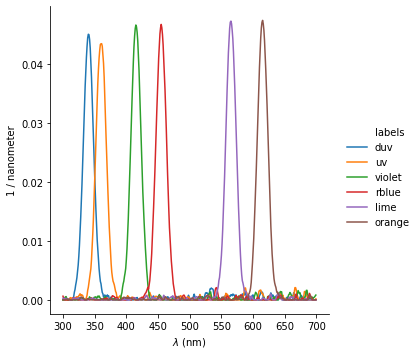

In [31]:
system.measured_spectra.normalized_spectra.plot()

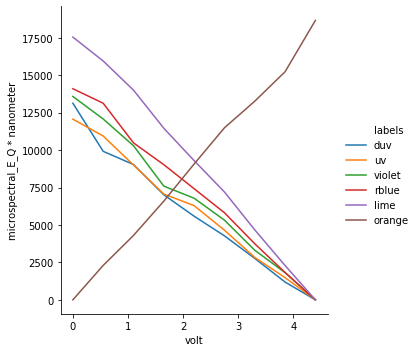

In [32]:
system.measured_spectra.intensities.plot()

You can simply map the measured intensity values to voltage output that you have to give. In this example, intensities are 30 microE_Q, and we are asking what voltage value must be applied to each LED to reach this intensity. 

In [34]:
system.measured_spectra.map(np.array([10000]*6))

array([0.4822412 , 0.84515121, 1.14133268, 1.26754484, 1.97658699,
       2.41095146]) <Unit('volt')>

In [35]:
points = np.random.randint(0, 10000, size=(20, 6))

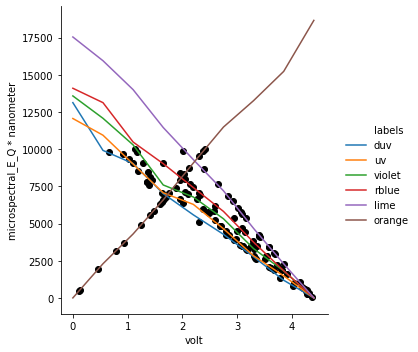

In [36]:
system.measured_spectra.intensities.plot()
plt.scatter(system.measured_spectra.map(points), points, color='black')

**spms** stores both the measured spectrum (intensity across volts) and the normalized spectrum plotted below, where each LED spectrum is normalized with as an integral of 1

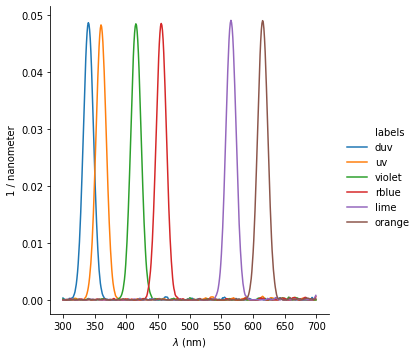

In [27]:
system.measured_spectra.normalized_spectra.plot()

Save the system instance that you have created (including the measurement (**spms**) and hardware settings)

In [22]:
runner.save('data/measurement_test.json')

In [23]:
runner.save('data/measurement_test.json.gz')

In [24]:
from dreye.io import read_pickle, write_pickle

In [25]:
import sys
#sys.getrecursionlimit()
#sys.setrecursionlimit(10000)

In [26]:
write_pickle('data/measurement_test.pkl.gz', runner)

In [27]:
runner = read_pickle('data/measurement_test.pkl.gz')

In [28]:
print(runner)

[MeasurementRunner]

DummySystem contains:
DummyOutput(object=Dev2/ao1, name=duv, max=0.0 volt, zero=4.4 volt)
DummyOutput(object=Dev3/ao1, name=uv, max=0.0 volt, zero=4.4 volt)
DummyOutput(object=Dev3/ao0, name=violet, max=0.0 volt, zero=4.4 volt)
DummyOutput(object=Dev1/ao1, name=rblue, max=0.0 volt, zero=4.4 volt)
DummyOutput(object=Dev2/ao0, name=lime, max=0.0 volt, zero=4.4 volt)
DummyOutput(object=Dev1/ao0, name=orange, max=5.0 volt, zero=0.0 volt)


Finally, you can reload the system to plot measurements, etc

In [29]:
from dreye.io import read_json

In [30]:
system_loaded = read_json('data/measurement_test.json')

In [31]:
print(system_loaded)

DummySystem contains:
DummyOutput(object=Dev2/ao1, name=duv, max=0.0 volt, zero=4.4 volt)
DummyOutput(object=Dev3/ao1, name=uv, max=0.0 volt, zero=4.4 volt)
DummyOutput(object=Dev3/ao0, name=violet, max=0.0 volt, zero=4.4 volt)
DummyOutput(object=Dev1/ao1, name=rblue, max=0.0 volt, zero=4.4 volt)
DummyOutput(object=Dev2/ao0, name=lime, max=0.0 volt, zero=4.4 volt)
DummyOutput(object=Dev1/ao0, name=orange, max=5.0 volt, zero=0.0 volt)


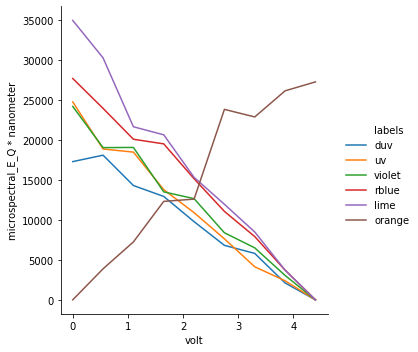

In [33]:
system_loaded.measured_spectra.intensities.plot()

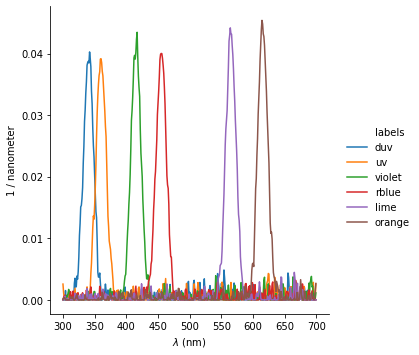

In [35]:
system.measured_spectra.normalized_spectra.plot()

After confirming that the code runs on your system, it's time to create your real measurements. Make sure that the subclasses you use are appropriate for your LED system and spectrophotometer. 